# Notebook for regridding using xarray

### Read in geometry and apply coarsen to WRF lats/lons:

In [1]:
import xarray as xr

geog = xr.open_dataset("/home/scratch/ahaberlie/simgeog/geo_em.d01.nc") #Open WRF lat/lon coords file

coarse_geog = geog[['CLAT', 'CLONG']].coarsen(south_north=20, west_east=20, boundary='trim').mean() #Find mean lat/lon of grid runs: averaging over 20 pixels is
                                                                                                    #roughly equivalent to 75 km (20 * 3.75 km = 75)

### New dimensions of lat/lon data are now 44 x 69 after averaging across 20 pixels (mean lat/lon of the 20th pixel run, or centroid)

## Create sample data to validate that this method upscales original data to ~75 x 75 km grid

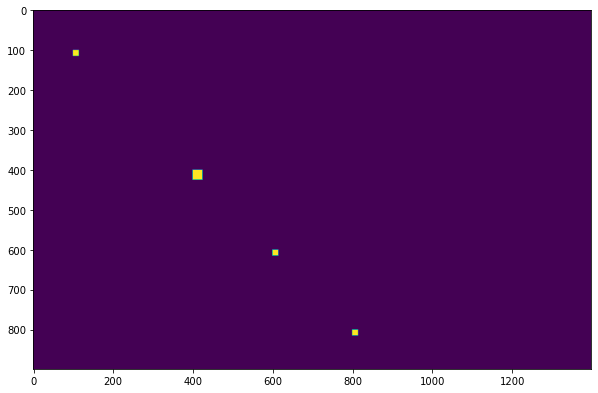

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
%matplotlib inline

plt.rcParams['figure.figsize'] = 10, 10

#this is simply the fastest way to make fake data and test this.. none of this is overly important
rand_eg = np.zeros(shape=(899, 1399))

rand_eg[400:425, 400:425] = 1
rand_eg[100:115, 100:115] = 1
rand_eg[600:615, 600:615] = 1
rand_eg[600:615, 600:615] = 1
rand_eg[800:815, 800:815] = 1

geog_test = deepcopy(geog[['CLAT', 'CLONG']])

geog_test['rand_eg'] = (('Time', 'south_north', 'west_east'), np.array([rand_eg]))

plt.imshow(geog_test['rand_eg'].values[0,:,:])

# Replicate above process using WRF hail day data

### Read in WRF HIST convective daily max .nc file

In [3]:
daily_max_hail = xr.open_dataset("/home/scratch/jgoodin/convective_daily_max_resamples/hist_daily_max_hail_inches.nc")

daily_max_hail #Resampled to daily max (12z - 12z) HAIL_MAX2D size for each day and grid cell

<xarray.Dataset>
Dimensions:     (Time: 5479, south_north: 899, west_east: 1399)
Coordinates:
  * Time        (Time) datetime64[ns] 1990-09-30T12:00:00 ... 2005-09-29T12:0...
Dimensions without coordinates: south_north, west_east
Data variables:
    HAIL_MAX2D  (Time, south_north, west_east) float32 ...

### Use year 2000 as test year

In [4]:
year_test = daily_max_hail.sel(Time = '2000')
year_test

<xarray.Dataset>
Dimensions:     (Time: 366, south_north: 899, west_east: 1399)
Coordinates:
  * Time        (Time) datetime64[ns] 2000-01-01T12:00:00 ... 2000-12-31T12:0...
Dimensions without coordinates: south_north, west_east
Data variables:
    HAIL_MAX2D  (Time, south_north, west_east) float32 ...

## Pass severe hail threshold

In [6]:
sev_hail_days = 1 * (year_test >= 0.0254) #Pass day threshold to this variable
sev_hail_days

<xarray.Dataset>
Dimensions:     (Time: 366, south_north: 899, west_east: 1399)
Coordinates:
  * Time        (Time) datetime64[ns] 2000-01-01T12:00:00 ... 2000-12-31T12:0...
Dimensions without coordinates: south_north, west_east
Data variables:
    HAIL_MAX2D  (Time, south_north, west_east) int64 0 0 0 0 0 0 ... 0 0 0 0 0 0

## Test plot one day that we know had hail to new grid

### Select hail day

In [17]:
test_day = sev_hail_days.sel(Time='2000-06-29T12:00:00.000000000')
test_day

<xarray.Dataset>
Dimensions:     (south_north: 899, west_east: 1399)
Coordinates:
    Time        datetime64[ns] 2000-06-29T12:00:00
Dimensions without coordinates: south_north, west_east
Data variables:
    HAIL_MAX2D  (south_north, west_east) int64 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0

#### Select HAIL_MAX2D variable to create plottable numpy array

In [18]:
test_day_var = test_day.HAIL_MAX2D

In [19]:
print(type(test_day_var))

<class 'xarray.core.dataarray.DataArray'>


# Plot single hail day data to new grid

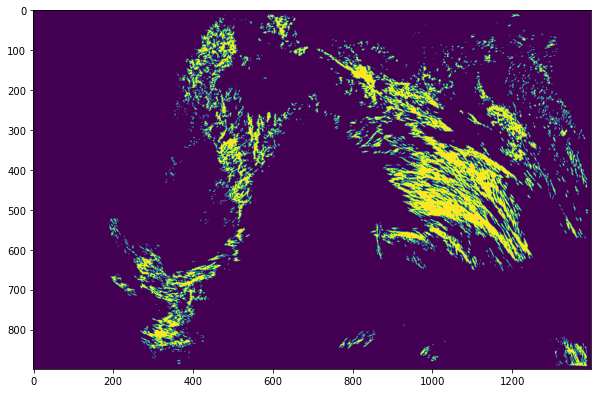

In [20]:
plt.rcParams['figure.figsize'] = 10, 10

geog_test_hail = deepcopy(geog[['CLAT', 'CLONG']])

geog_test_hail['test_day_var'] = (('Time', 'south_north', 'west_east'), np.array([test_day_var]))

plt.imshow(geog_test_hail['test_day_var'].values[0,:,:])

# Coarsen the data

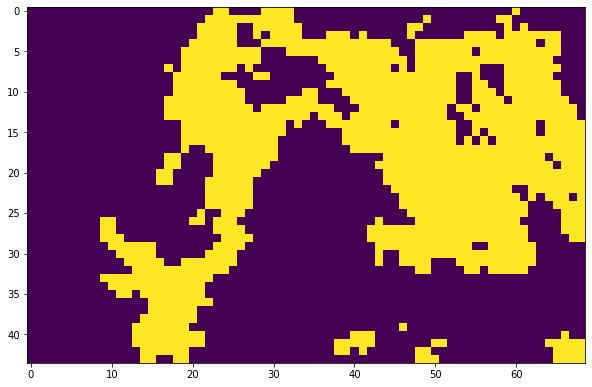

In [21]:
coarse_geog_test = geog_test_hail[['test_day_var']].coarsen(south_north=20, west_east=20, boundary='trim').max()

plt.imshow(coarse_geog_test['test_day_var'].values[0,:,:])

## To see if geometry lines up, plot coarsened grid over top of regular grid using transparency (alpha):

### New grid is outlined in white (approx. 75 x 75 km)

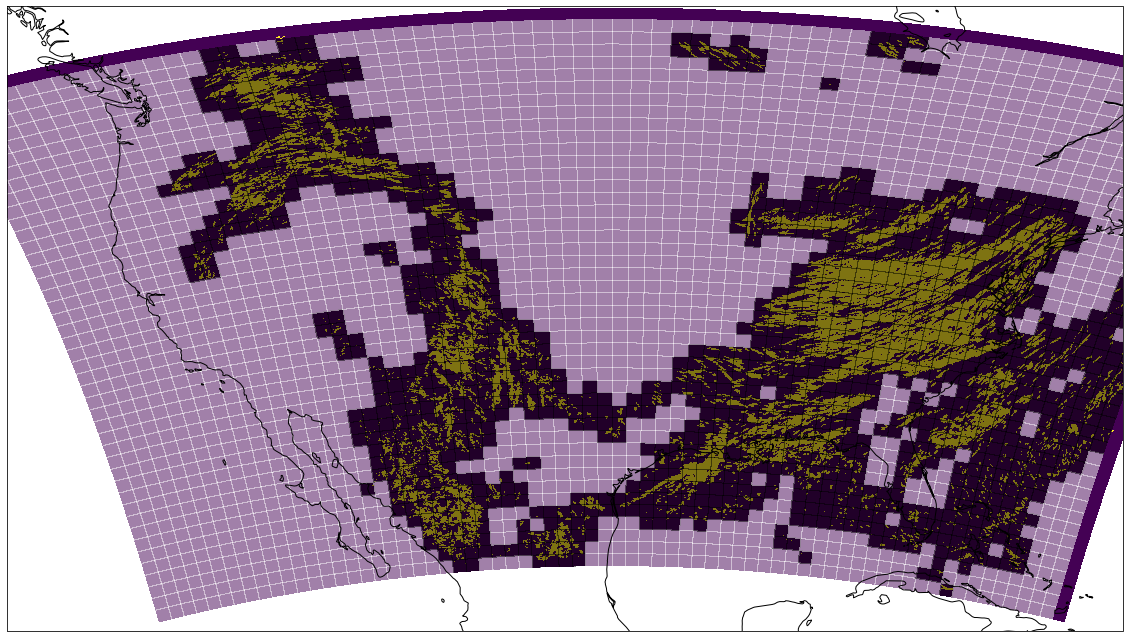

In [22]:
import cartopy
import cartopy.crs as ccrs

"""
plt.rcParams['figure.figsize'] = 20, 20

ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-130, -70, 20, 50])
ax.coastlines()

ax.pcolormesh(geog['CLONG'].values[0,:,:], geog['CLAT'].values[0,:,:], test_day_var, 
              shading='nearest', transform=ccrs.PlateCarree())

ax.pcolormesh(coarse_geog['CLONG'].values[0,:,:], coarse_geog['CLAT'].values[0,:,:], coarse_geog_test['test_day_var'].values[0,:,:], 
              shading='nearest', transform=ccrs.PlateCarree(), cmap='Greys', alpha=0.5)
"""


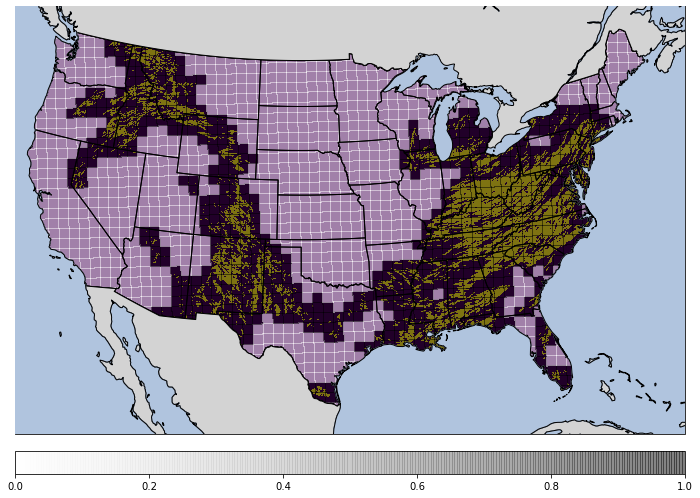

In [31]:
import cartopy
import cartopy.crs as ccrs
import matplotlib.gridspec as gridspec
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

fig = plt.figure(figsize= (12,8)) #Plot a figure
gs1 = gridspec.GridSpec(2, 1, height_ratios=[1, .05], bottom=.05, top=.95, wspace=.1)
map_proj = ccrs.LambertConformal(central_longitude = -100, central_latitude = 35) #Set projection, central lat/lon
ax = plt.subplot(projection = map_proj)
ax.set_extent([240,287,22,50])
ax.add_feature(cfeature.LAND.with_scale('10m')) #Add land
countries_shp = shpreader.natural_earth(resolution='50m',
                                     category='cultural',
                                     name='admin_0_countries')
for country, info in zip(shpreader.Reader(countries_shp).geometries(), 
                             shpreader.Reader(countries_shp).records()):
        if info.attributes['NAME_LONG'] != 'United States':

            ax.add_geometries([country], ccrs.PlateCarree(),
                             facecolor='lightgrey', edgecolor='k', zorder=6)
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'coastline', '50m', edgecolor='k', 
                                                facecolor='None'), zorder=8) 
ax.add_feature(cfeature.BORDERS.with_scale('10m')) #Add state borders
ax.add_feature(cfeature.STATES.with_scale('10m'), facecolor = 'none') #Add US states
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='face', 
                                                facecolor='lightsteelblue'), zorder=6)
lakes_shp = shpreader.natural_earth(resolution='50m',
                                     category='physical',
                                     name='lakes')
for lake, info in zip(shpreader.Reader(lakes_shp).geometries(), 
                             shpreader.Reader(lakes_shp).records()):
        name = info.attributes['name']
        if name == 'Lake Superior' or name == 'Lake Michigan' or \
           name == 'Lake Huron' or name == 'Lake Erie' or name == 'Lake Ontario':
            
            ax.add_geometries([lake], ccrs.PlateCarree(),
                             facecolor='lightsteelblue', edgecolor='k', zorder=6)

lrFig = ax.pcolormesh(geog['CLONG'].values[0,:,:], geog['CLAT'].values[0,:,:], test_day_var, 
              shading='nearest', transform=ccrs.PlateCarree())
mmp = ax.pcolormesh(coarse_geog['CLONG'].values[0,:,:], coarse_geog['CLAT'].values[0,:,:], coarse_geog_test['test_day_var'].values[0,:,:], 
              shading='nearest', transform=ccrs.PlateCarree(), cmap='Greys', alpha=0.5)

ax2 = plt.subplot(gs1[1, 0])  
cb1 = plt.colorbar(mmp, cax = ax2, orientation = 'horizontal')
plt.subplots_adjust(bottom=0.1)